<a href="https://colab.research.google.com/github/ziatdinovmax/AugmentedGaussianProcess/blob/main/sGPBO_forrester.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebooks compares Bayesian optimization based on classical Gaussian process (GP) and on GP augmented by a structured probabilistic model of expected system's behavior. We are going to use a slightly modified version of the [Forester function](https://www.sfu.ca/~ssurjano/forretal08.html) that has local and global minima with the goal to identify the global minimum using the smallest number of steps.

*Prepared by Maxim Ziatdinov (August 2021)*

List CPU specs:

In [1]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           AuthenticAMD
CPU family:          23
Model:               49
Model name:          AMD EPYC 7B12
Stepping:            0
CPU MHz:             2249.998
BogoMIPS:            4499.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            512K
L3 cache:            16384K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid tsc_known_freq pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm cmp_legacy cr8_legacy abm sse4a misalignss

Install NumPyro (for [iterative No-U-Turn Sampler](https://github.com/pyro-ppl/numpyro/wiki/Iterative-NUTS))

In [2]:
!pip install -q numpyro

Imports:

In [3]:
from typing import Union, Dict, Type

from functools import partial

import jax.numpy as jnp
from jax import jit
import jax.random as jra
from jax.scipy import linalg as jLA
import jax
from jax.interpreters import xla

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median

import numpy as onp
import matplotlib.pyplot as plt

numpyro.enable_x64()

if jax.__version__ < '0.2.26':
    clear_cache = jax.interpreters.xla._xla_callable.cache_clear
else:
    clear_cache = jax._src.dispatch._xla_callable.cache_clear

Run the next four cells to load kernel functions, base GP class, acquisition functions and plotting utilities  👇👇👇

In [4]:
#@title Kernel functions 🛠️ { form-width: "20%" }

def _sqrt(x, eps=1e-12):
    return jnp.sqrt(x + eps)

def add_jitter(x, jitter=1e-6):
    return x + jitter

def square_scaled_distance(X: jnp.ndarray, Z: jnp.ndarray,
                           lengthscale: Union[jnp.ndarray, float] = 1.
                           ) -> jnp.ndarray:
    scaled_X = X / lengthscale
    scaled_Z = Z / lengthscale
    X2 = (scaled_X ** 2).sum(1, keepdims=True)
    Z2 = (scaled_Z ** 2).sum(1, keepdims=True)
    XZ = jnp.matmul(scaled_X, scaled_Z.T)
    r2 = X2 - 2 * XZ + Z2.T
    return r2.clip(0)

@jit
def RBFKernel(X: jnp.ndarray, Z: jnp.ndarray,
              params: Dict[str, jnp.ndarray],
              noise: int = 0, **kwargs: float) -> jnp.ndarray:
    r2 = square_scaled_distance(X, Z, params["k_length"])
    k = params["k_scale"] * jnp.exp(-0.5 * r2)
    if X.shape == Z.shape:
        k += add_jitter(noise, **kwargs) * jnp.eye(X.shape[0])
    return k


@jit
def MaternKernel(X: jnp.ndarray, Z: jnp.ndarray,
                 params: Dict[str, jnp.ndarray],
                 noise: int = 0, **kwargs: float) -> jnp.ndarray:
    r2 = square_scaled_distance(X, Z, params["k_length"])
    r = _sqrt(r2)
    sqrt5_r = 5**0.5 * r
    k = params["k_scale"] * (1 + sqrt5_r + (5/3) * r2) * jnp.exp(-sqrt5_r)
    if X.shape == Z.shape:
        k += add_jitter(noise, **kwargs) * jnp.eye(X.shape[0])
    return k

In [5]:
#@title Gausian process: base class 🛠️{ form-width: "20%" }

class ExactGP:

    def __init__(self, input_dim, kernel, mean_fn=None):  # e.g. ExactGP(input_dim=2, kernel=RBFKernel)
        clear_cache()
        self.input_dim = input_dim
        self.kernel = kernel
        self.mean_fn = mean_fn
        self.X_train = None
        self.y_train = None
        self.mcmc = None

    def model(self, X, y):
        """GP model"""
        # Initialize mean function at zeros
        f_loc = jnp.zeros(X.shape[0])
        # Sample kernel parameters and noise
        with numpyro.plate('k_param', self.input_dim):  # allows using ARD kernel for input_dim > 1
            length = numpyro.sample("k_length", dist.LogNormal(0.0, 1.0))
        scale = numpyro.sample("k_scale", dist.LogNormal(0.0, 1.0))
        noise = numpyro.sample("noise", dist.LogNormal(0.0, 1.0))
        # Add mean function (if any)
        if self.mean_fn is not None:
            f_loc += self.mean_fn(X).squeeze()
        # compute kernel
        k = self.kernel(
            X, X,
            {"k_length": length, "k_scale": scale},
            noise
        )
        # sample y according to the standard Gaussian process formula
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
            obs=y,
        )

    def fit(self, rng_key, X, y,
            num_warmup=2000, num_samples=2000, num_chains=1,
            progress_bar=True, print_summary=True):
        """
        Run MCMC to infer the GP model parameters
        """
        X = X if X.ndim > 1 else X[:, None]
        self.X_train = X
        self.y_train = y

        init_strategy = numpyro.infer.init_to_median(num_samples=10)
        kernel = NUTS(self.model, init_strategy=init_strategy)
        self.mcmc = MCMC(
            kernel,
            num_warmup=num_warmup,
            num_samples=num_samples,
            num_chains=num_chains,
            progress_bar=progress_bar,
            jit_model_args=False
        )
        self.mcmc.run(rng_key, X, y)
        if print_summary:
            self.mcmc.print_summary()
    
    def get_samples(self, chain_dim=False):
        """Get posterior samples (after running the MCMC chains)"""
        return self.mcmc.get_samples(group_by_chain=chain_dim)

    @partial(jit, static_argnames='self')
    def get_mvn_posterior(self, X_test, params):
        """
        Returns parameters (mean and cov) of multivariate normal posterior
        for a single sample of GP hyperparameters
        """
        noise = params["noise"]
        y_residual = self.y_train
        if self.mean_fn is not None:
            y_residual -= self.mean_fn(self.X_train, params).squeeze()
        # compute kernel matrices for train and test data
        k_pp = self.kernel(X_test, X_test, params, noise)
        k_pX = self.kernel(X_test, self.X_train, params, jitter=0.0)
        k_XX = self.kernel(self.X_train, self.X_train, params, noise)
        # compute the predictive covariance and mean
        K_xx_inv = jnp.linalg.inv(k_XX)
        cov = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))
        mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, y_residual))
        if self.mean_fn is not None:
            mean += self.mean_fn(X_test, params).squeeze()
        return mean, cov
        
    def _predict(self, rng_key, X_test, params, n):
        """Prediction with a single sample of GP hyperparameters"""
        X_test = X_test if X_test.ndim > 1 else X_test[:, None]
        # Get the predictive mean and covariance
        y_mean, K = self.get_mvn_posterior(X_test, params)
        # draw samples from the posterior predictive for a given set of hyperparameters
        y_sample = dist.MultivariateNormal(y_mean, K).sample(rng_key, sample_shape=(n,))
        return y_mean, y_sample.squeeze()
    
    def predict(self, rng_key, X_test, samples=None, n=1):
        """Make prediction at X_test points using sampled GP hyperparameters"""
        if samples is None:
            samples = self.get_samples(chain_dim=False)
        num_samples = samples["k_length"].shape[0]
        # use vmap for 'vectorization'
        vmap_args = (jra.split(rng_key, num_samples), samples)
        predictive = jax.vmap(lambda params:
                        self._predict(params[0], X_test, params[1], n))
        y_means, y_sampled = predictive(vmap_args)
        return y_means.mean(0), y_sampled

In [6]:
#@title Acquisition functions 🛠️ { form-width: "20%" }

def EI(rng_key: jnp.ndarray, model: Type[ExactGP],
       X: jnp.ndarray, xi: float = 0.01,
       maximize: bool = False, n: int = 1) -> jnp.ndarray:
    """
    Expected Improvement
    """
    y_mean, y_sampled = model.predict(rng_key, X, n=n)
    if n > 1:
        y_sampled = y_sampled.reshape(n * y_sampled.shape[0], -1)
    mean, sigma = y_sampled.mean(0), y_sampled.std(0)
    u = (mean - y_mean.max() - xi) / sigma
    u = -u if not maximize else u
    normal = dist.Normal(jnp.zeros_like(u), jnp.ones_like(u))
    ucdf = normal.cdf(u)
    updf = jnp.exp(normal.log_prob(u))
    return sigma * (updf + u * ucdf) 


def UCB(rng_key: jnp.ndarray, model: Type[ExactGP],
        X: jnp.ndarray, beta: float = .25,
        maximize: bool = False, n: int = 1) -> jnp.ndarray:
    """
    Upper confidence bound
    """
    _, y_sampled = model.predict(rng_key, X, n=n)
    if n > 1:
        y_sampled = y_sampled.reshape(n * y_sampled.shape[0], -1)
    mean, var= y_sampled.mean(0), y_sampled.var(0)
    delta = jnp.sqrt(beta * var)
    if maximize:
        return mean + delta
    return mean - delta 


def UE(rng_key: jnp.ndarray,
       model: Type[ExactGP],
       X: jnp.ndarray, n: int = 1) -> jnp.ndarray:
    """Uncertainty-based exploration (aka kriging)"""
    _, y_sampled = model.predict(rng_key, X, n=n)
    return y_sampled.var(0)


def Thompson(rng_key: jnp.ndarray,
             model: Type[ExactGP],
             posterior_samples: Dict[str, jnp.ndarray],
             X: jnp.ndarray, n: int = 1) -> jnp.ndarray:
    """Thompson sampling"""
    posterior_samples = model.get_samples()
    idx = jra.randint(rng_key, (1,), 0, len(posterior_samples["k_length"]))
    samples = {k: v[idx] for (k, v) in posterior_samples.items()}
    _, tsample = model.predict(rng_key, X, samples, n)
    if n > 1:
        tsample = tsample.mean(1)
    return tsample.squeeze()

In [7]:
#@title Plotting and data utilities 🛠️ { form-width: "20%" }

def get_training_data(X, Y, num_seed_points=2, rng_seed=42, **kwargs):
    onp.random.seed(rng_seed)
    indices = jnp.arange(len(X))
    idx = kwargs.get("list_of_indices")
    if idx is not None:
        idx = onp.array(idx)
    else:
        idx = onp.random.randint(0, len(X), num_seed_points)
    idx = onp.unique(idx)
    X_train, y_train = X[idx], Y[idx]
    indices_train = indices[idx]
    X_test = jnp.delete(X, idx)
    y_test = jnp.delete(Y, idx)
    indices_test = jnp.delete(indices, idx)
    return X_train, y_train, X_test, y_test, indices_train, indices_test
    

def plot_acq(x, obj, idx):
    plt.plot(x.squeeze(), obj, c='k')
    plt.vlines(x[idx], obj.min(), obj.max(), linestyles='dashed')
    plt.xlabel("$x$", fontsize=18)
    plt.ylabel("Acquisition function", fontsize=18)
    plt.show()
    

def plot_final_result(X_train, y_train, y_pred, *args, num_seed_points=2):
    plt.figure(dpi=100)
    plt.scatter(X_train[seed_points:], y_train[seed_points:], c=jnp.arange(1, len(X_train[seed_points:])+1),
                cmap='viridis', label="Sampled points", zorder=0)
    cbar = plt.colorbar(label="Exploration step")
    cbar_ticks = onp.arange(2, len(X_train[num_seed_points:]) + 1, 2)
    cbar.set_ticks(cbar_ticks)
    plt.scatter(X_train[:seed_points], y_train[:seed_points], marker='x', s=64,
                c='k', label="Seed points", zorder=1)
    plt.plot(X, truefunc, c='k', label='True function', zorder=0)
    plt.plot(X, y_pred, '--', c='red', label='Model reconstruction', zorder=0)
    if len(args) > 0:
        y_sampled = args[0]
        plt.fill_between(X, y_pred - y_sampled.std(0), y_pred + y_sampled.std(0),
                         color='r', alpha=0.2, label="Model uncertainty")
    plt.legend()
    plt.show()

## Objective function and standard GP "fitting"

Define our objective function:

In [8]:
def forrester_func(x, params):
    return (params["A"] * x + params["x01"])**2 * jnp.sin(params["B"] * x + params["x02"])

def get_data(N=100, noise_level=0):
    onp.random.seed(1)
    X = jnp.linspace(0, 1, N)
    X_test = jnp.linspace(0, 1, N*2)
    truefunc = forrester_func(X, {"A": 5, "x01": -2, "B": 12, "x02": -4})
    Y = truefunc + noise_level * onp.random.normal(size=X.shape)
    return X, Y, truefunc, X_test

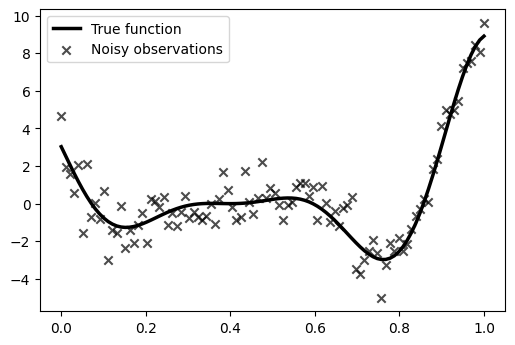

In [9]:
plt.figure(dpi=100)
X, Y, truefunc, X_test = get_data(N=100, noise_level=1)
plt.scatter(X, Y, marker='x', c='k', zorder=0, label='Noisy observations', alpha=0.7)
plt.plot(X, truefunc, c='k', lw=2.5, zorder=1, label='True function')
plt.legend()

Do a standard GP (no optimization) on all the 'observed' data:

In [10]:
# Get random number generators for train and test stages
# (see JAX documentation for details on why we need them)
rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

# initialize model
gp_model = ExactGP(1, RBFKernel)
# Obtain GP posterior
gp_model.fit(rng_key, X, Y, num_chains=1)
# Make a prediction
y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test)

sample: 100%|██████████| 4000/4000 [00:30<00:00, 129.61it/s, 7 steps of size 5.65e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.13      0.02      0.13      0.10      0.16   1254.42      1.00
    k_scale     12.43      6.52     10.87      4.13     20.63   1169.06      1.00
      noise      0.84      0.13      0.83      0.63      1.05   1292.40      1.00

Number of divergences: 0


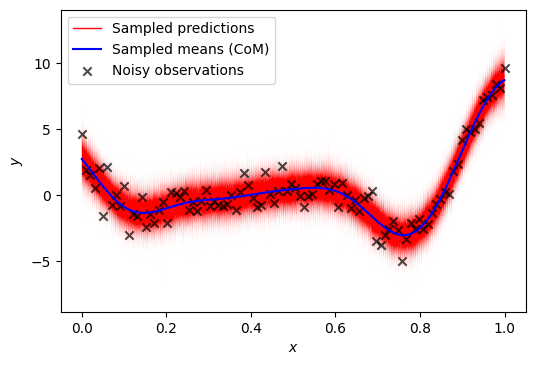

In [11]:
_, ax = plt.subplots(dpi=100)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.scatter(X, Y, marker='x', c='k', zorder=2, label="Noisy observations", alpha=0.7)
for y1 in y_sampled:
    ax.plot(X_test, y1, lw=.02, zorder=1, c='r', alpha=.1)
l, = ax.plot(X_test, y_sampled[0], lw=1, zorder=0, c='r', alpha=1, label="Sampled predictions")
ax.plot(X_test, y_pred, lw=1.5, zorder=2, c='b', label='Sampled means (CoM)')
ax.legend()
l.set_alpha(0)

## Bayesian Optimizations with Standard GP

In [12]:
seed_points = 2

X, Y, truefunc, _ = get_data(noise_level=1)

(X_train, y_train, X_test, y_test,
 indices_train, indices_test) = get_training_data(X, Y, seed_points, 10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2,) (98,) (2,) (98,)


Do Bayesian optimization with a standard GP:





1/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 7346.36it/s, 3 steps of size 8.11e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.63      2.13      0.98      0.04      3.60   8266.21      1.00
    k_scale      1.70      1.85      1.13      0.07      3.69   6450.85      1.00
      noise      1.73      1.67      1.25      0.17      3.52   8384.04      1.00

Number of divergences: 0


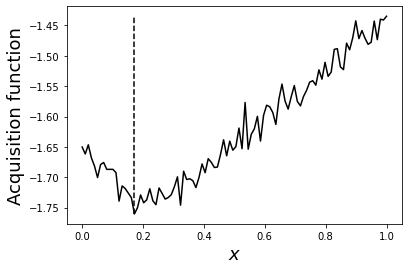

2/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 7241.49it/s, 7 steps of size 6.67e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.60      2.26      0.95      0.03      3.48   6342.23      1.00
    k_scale      1.99      2.06      1.38      0.09      4.19   8356.94      1.00
      noise      1.37      1.37      0.97      0.12      2.74   6629.90      1.00

Number of divergences: 0


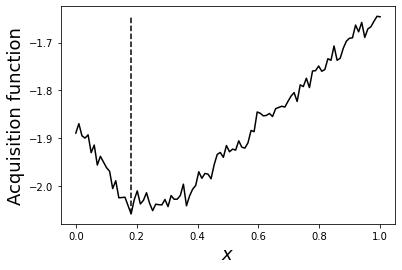

3/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 7114.02it/s, 7 steps of size 7.88e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.64      2.25      0.98      0.04      3.57   6340.69      1.00
    k_scale      1.91      1.92      1.34      0.07      3.86   8371.47      1.00
      noise      1.12      0.99      0.83      0.14      2.18   7165.09      1.00

Number of divergences: 0


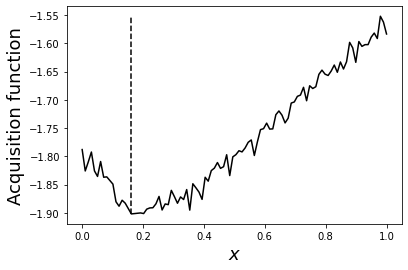

4/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 4852.98it/s, 7 steps of size 7.15e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.64      2.01      1.00      0.05      3.61   7764.87      1.00
    k_scale      1.93      1.89      1.40      0.16      3.88   7344.59      1.00
      noise      0.87      0.76      0.66      0.14      1.65   6803.68      1.00

Number of divergences: 0


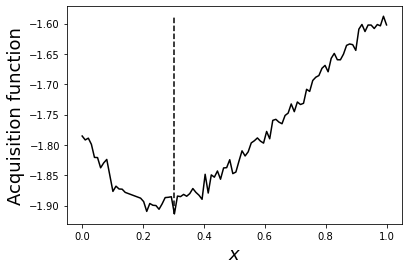

5/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 6424.82it/s, 7 steps of size 7.10e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.65      2.20      1.01      0.05      3.54   7255.57      1.00
    k_scale      1.81      1.90      1.28      0.17      3.70   6960.84      1.00
      noise      0.79      0.59      0.63      0.16      1.46   6806.21      1.00

Number of divergences: 0


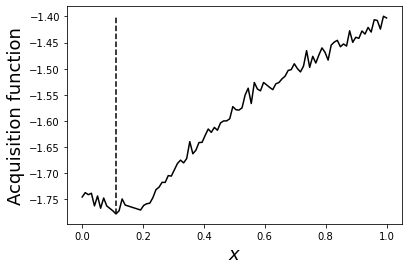

6/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 6316.02it/s, 7 steps of size 7.41e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.59      2.02      0.97      0.06      3.44   7075.11      1.00
    k_scale      2.02      1.98      1.46      0.18      4.05   5925.83      1.00
      noise      1.03      0.68      0.85      0.23      1.82   6554.75      1.00

Number of divergences: 0


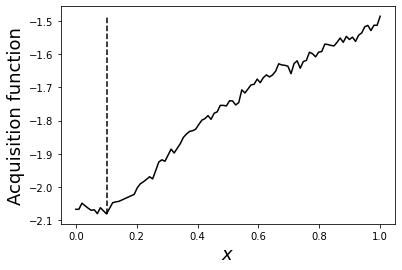

7/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 6293.67it/s, 7 steps of size 6.90e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.67      2.26      1.03      0.05      3.61   6926.74      1.00
    k_scale      1.72      1.86      1.19      0.09      3.50   7958.41      1.00
      noise      1.56      0.88      1.35      0.52      2.68   7177.31      1.00

Number of divergences: 0


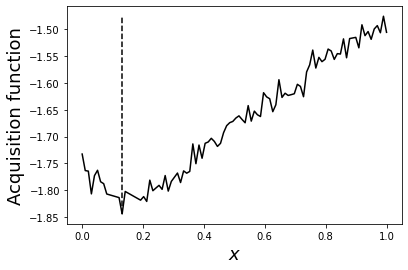

8/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 6092.61it/s, 7 steps of size 7.87e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.67      2.29      1.01      0.06      3.60   7074.82      1.00
    k_scale      1.72      1.72      1.23      0.13      3.52   7461.27      1.00
      noise      1.38      0.73      1.21      0.47      2.33   6685.44      1.00

Number of divergences: 0


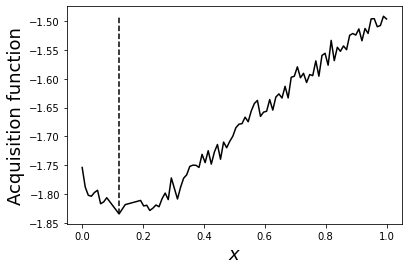

9/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 5795.00it/s, 11 steps of size 8.37e-01. acc. prob=0.90]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.67      2.10      1.02      0.06      3.67   7196.22      1.00
    k_scale      1.76      1.77      1.24      0.15      3.62   7673.13      1.00
      noise      1.25      0.63      1.10      0.47      2.11   7010.18      1.00

Number of divergences: 0


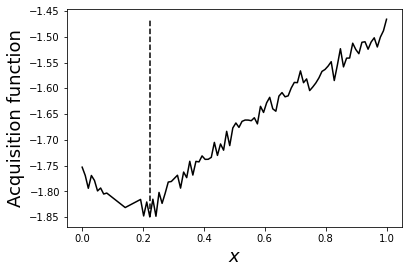

10/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 5549.83it/s, 7 steps of size 6.72e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.64      2.08      1.02      0.05      3.56   7584.59      1.00
    k_scale      1.65      1.68      1.15      0.11      3.37   7087.06      1.00
      noise      1.32      0.62      1.17      0.50      2.13   7524.76      1.00

Number of divergences: 0


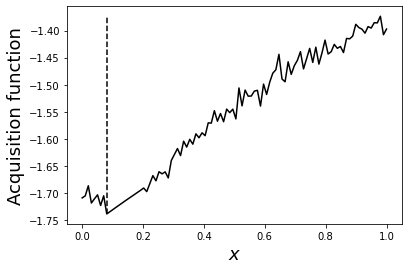

11/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 5636.16it/s, 7 steps of size 6.54e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.65      2.06      1.01      0.04      3.60   7490.99      1.00
    k_scale      1.54      1.60      1.07      0.12      3.19   7203.46      1.00
      noise      1.33      0.59      1.20      0.52      2.12   8262.25      1.00

Number of divergences: 0


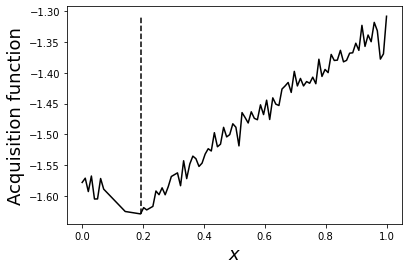

12/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 5319.35it/s, 11 steps of size 8.45e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.69      2.13      1.04      0.03      3.65   7736.92      1.00
    k_scale      1.52      1.60      1.06      0.10      3.11   7305.69      1.00
      noise      1.26      0.54      1.15      0.53      1.99   7907.05      1.00

Number of divergences: 0


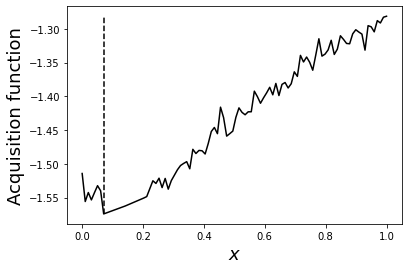

In [13]:
exploration_steps = 12
acq_fn = UCB  #EI

rng_key, rng_key_predict = jra.split(jra.PRNGKey(1))

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # Initiate GP model
    gp_model = ExactGP(1, RBFKernel)
    # Get/update GP posterior
    gp_model.fit(rng_key, X_train, y_train, num_warmup=1000, num_samples=1000, num_chains=10)
    # Compute acquisition 
    obj = acq_fn(rng_key_predict, gp_model, X_test, n=1)
    # Find maximum/minimum of acquisiton function to select the next "measurement" point
    next_point_idx = obj.argmax() if acq_fn in (EI, UE) else obj.argmin()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot acquisition function
    plot_acq(X_test, obj, next_point_idx)
    # Append to the arrays of measured points
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, measured_point)
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point)
    indices_test = jnp.delete(indices_test, next_point_idx)

Plot results together with GP prediction on the final set of discovered points:

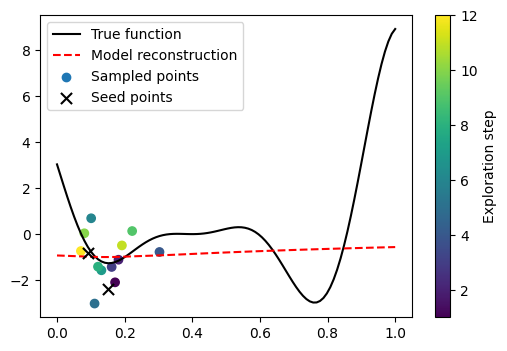

In [14]:
y_pred, _ = gp_model.predict(rng_key_predict, X)
plot_final_result(X_train, y_train, y_pred, num_seed_points=seed_points)

## Bayesian Optimizations with GP augmented by probabilistic model

### Probabilistic model 1

Here we define our probabilistic model as a function with two inverted peaks. In another words, it is a very rough guess about the true form of our objective function. Nevertheless, as we show below, it will allow for a much more efficient Bayesian optimization.

We are going to write our GP models with probabilistic mean functions by subclassing the base GP class and redefining the model.

In [15]:
def doubleLorentzfunc(x, params):
    return (params["y0"] - (params["A1"]/((x-params["x01"])**2+params["w1"]**2)**(1/2) +
            params["A2"]/((x-params["x02"])**2+params["w2"]**2)**(1/2)))

In [16]:
class GP1(ExactGP):

    def __init__(self, input_dim, kernel):
        super(GP1, self).__init__(input_dim, kernel)
        self.mean_fn=doubleLorentzfunc

    def model(self, X, y):

        # Mean function parameters
        y0 = numpyro.sample("y0", dist.Uniform(-10, 10))
        x01 = numpyro.sample("x01", dist.Uniform(0, 0.5))
        x02 = numpyro.sample("x02", dist.Uniform(0.5, 0.9))
        A1 = numpyro.sample("A1", dist.LogNormal(0, 1))
        A2 = numpyro.sample("A2", dist.LogNormal(0, 1))
        w1 = numpyro.sample("w1", dist.HalfNormal(.1))
        w2 = numpyro.sample("w2", dist.HalfNormal(.1))
            # kernel parameters
        with numpyro.plate('k_param', self.input_dim):
            length = numpyro.sample("k_length", dist.LogNormal(0.0, 1))
        scale = numpyro.sample("k_scale", dist.LogNormal(0.0, 1))
        noise = numpyro.sample("noise", dist.LogNormal(0.0, 1))
        # compute mean function
        mean_fn_params = {"y0": y0, "x01": x01, "x02": x02,
                          "A1": A1, "A2": A2, "w1": w1, "w2": w2}
        
        f_loc = self.mean_fn(X, mean_fn_params).squeeze()

        # compute kernel
        k = self.kernel(
            X, X,
            {"k_length": length, "k_scale": scale},
            noise
        )
        # sample y according to the standard gaussian process formula
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
            obs=y,
        )

Initialize "train/test" data:

In [17]:
seed_points = 2

X, Y, truefunc, _ = get_data(noise_level=1)

(X_train, y_train, X_test, y_test,
 indices_train, indices_test) = get_training_data(X, Y, seed_points, 10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2,) (98,) (2,) (98,)


Do Bayesian optimization with GP augmented by a probabilsitic model of expected system's behavior:

1/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 4000.27it/s, 15 steps of size 1.26e-01. acc. prob=0.84]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.89      0.67      0.70      0.06      1.87   4665.59      1.00
         A2      1.26      1.08      0.94      0.05      2.73   6173.87      1.00
k_length[0]      1.67      2.09      1.03      0.03      3.70   6606.57      1.00
    k_scale      1.65      2.14      1.02      0.05      3.64   5806.88      1.00
      noise      1.26      1.53      0.80      0.06      2.70   5775.99      1.00
         w1      0.09      0.06      0.08      0.00      0.17   6155.22      1.00
         w2      0.08      0.06      0.07      0.00      0.17   8070.71      1.00
        x01      0.32      0.12      0.34      0.16      0.50   5648.35      1.00
        x02      0.70      0.11      0.70      0.52      0.88   7930.85      1.00
         y0      4.33      2.82      4.31      0.33      9.51   5007.92      1.00

Number of divergences: 67


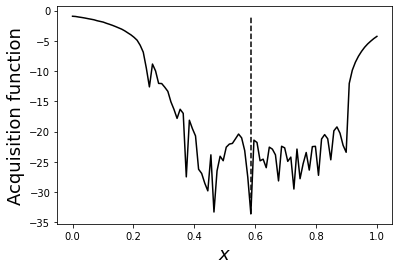

2/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 3534.41it/s, 31 steps of size 1.17e-01. acc. prob=0.85]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.83      0.50      0.71      0.12      1.53   3992.75      1.00
         A2      0.55      0.41      0.44      0.04      1.12   3321.62      1.00
k_length[0]      1.63      1.98      1.00      0.04      3.66   4467.81      1.00
    k_scale      1.64      1.97      0.99      0.05      3.71   5795.53      1.00
      noise      1.35      1.62      0.86      0.05      2.94   4951.70      1.00
         w1      0.10      0.06      0.09      0.00      0.17   5278.46      1.00
         w2      0.10      0.07      0.09      0.00      0.19   4091.20      1.00
        x01      0.22      0.08      0.23      0.08      0.35   3544.41      1.00
        x02      0.75      0.11      0.78      0.56      0.90   4042.77      1.00
         y0      4.75      2.53      4.69      1.14      9.40   3004.96      1.00

Number of divergences: 72


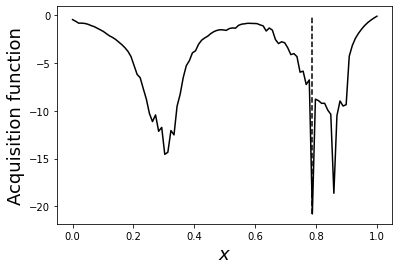

3/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 3269.78it/s, 11 steps of size 1.41e-01. acc. prob=0.77]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.77      0.48      0.66      0.08      1.49    138.74      1.07
         A2      0.56      0.34      0.49      0.09      1.03   3586.92      1.00
k_length[0]      1.80      3.43      0.96      0.05      3.48    297.79      1.04
    k_scale      1.56      1.97      0.99      0.04      3.43   4668.99      1.00
      noise      1.33      1.54      0.87      0.04      2.91    664.04      1.02
         w1      0.10      0.06      0.09      0.00      0.17    582.25      1.02
         w2      0.09      0.06      0.07      0.00      0.16   1026.00      1.02
        x01      0.22      0.09      0.23      0.05      0.35   3093.31      1.00
        x02      0.80      0.07      0.82      0.72      0.90    454.72      1.03
         y0      4.12      2.53      3.99      0.05      8.19    234.42      1.05

Number of divergences: 528


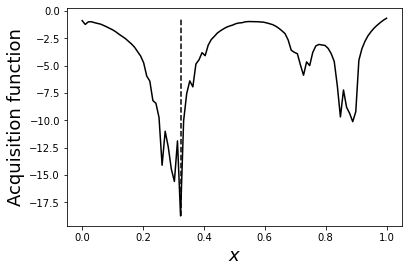

4/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2850.39it/s, 31 steps of size 9.70e-02. acc. prob=0.80]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.59      0.39      0.50      0.09      1.16   2474.79      1.00
         A2      0.56      0.35      0.48      0.09      1.03   2461.30      1.00
k_length[0]      1.67      2.10      1.03      0.04      3.63   4844.11      1.00
    k_scale      1.56      2.11      0.96      0.03      3.39   3037.84      1.00
      noise      1.17      1.23      0.81      0.07      2.44   3228.61      1.00
         w1      0.12      0.06      0.11      0.01      0.21   2402.28      1.00
         w2      0.09      0.06      0.08      0.00      0.16   2683.76      1.00
        x01      0.18      0.08      0.19      0.00      0.25   2566.17      1.00
        x02      0.81      0.07      0.83      0.72      0.90   2567.11      1.00
         y0      3.44      2.34      3.25     -0.46      7.32   1969.69      1.01

Number of divergences: 336


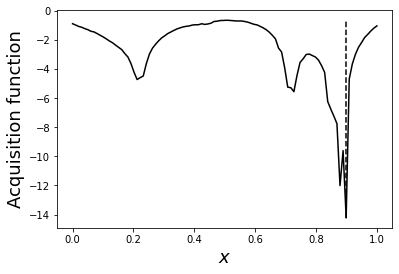

5/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2525.81it/s, 15 steps of size 9.93e-02. acc. prob=0.83]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.92      0.55      0.82      0.12      1.71   1399.56      1.02
         A2      0.54      0.29      0.51      0.09      0.92   3616.70      1.00
k_length[0]      1.47      2.04      0.85      0.04      3.15   1680.44      1.00
    k_scale      1.92      2.48      1.13      0.04      4.23    885.52      1.01
      noise      2.56      2.22      1.96      0.15      5.29   1426.73      1.01
         w1      0.12      0.06      0.12      0.02      0.21   1975.95      1.01
         w2      0.07      0.06      0.05      0.00      0.15   1780.36      1.00
        x01      0.19      0.08      0.19      0.01      0.27   3968.55      1.00
        x02      0.72      0.06      0.73      0.63      0.83   2737.08      1.00
         y0      5.82      2.49      5.98      2.43     10.00   1277.11      1.01

Number of divergences: 481


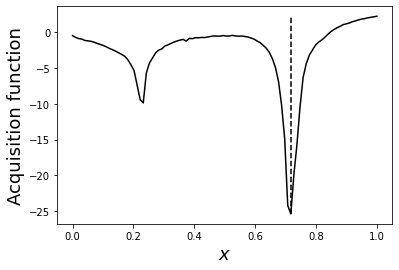

6/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2507.13it/s, 11 steps of size 1.49e-01. acc. prob=0.81]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.89      0.55      0.78      0.10      1.67   1804.65      1.00
         A2      0.59      0.34      0.52      0.11      1.07   3264.69      1.00
k_length[0]      1.47      1.93      0.88      0.03      3.33   4870.78      1.00
    k_scale      1.84      2.29      1.11      0.06      4.20   5065.72      1.00
      noise      2.71      2.19      2.14      0.14      5.33   2067.40      1.00
         w1      0.12      0.06      0.12      0.03      0.22   2241.61      1.01
         w2      0.08      0.05      0.08      0.01      0.15   2704.12      1.00
        x01      0.19      0.09      0.19      0.00      0.28   3596.68      1.00
        x02      0.72      0.05      0.73      0.64      0.80   2633.21      1.00
         y0      5.60      2.55      5.72      2.13     10.00   1708.57      1.00

Number of divergences: 200


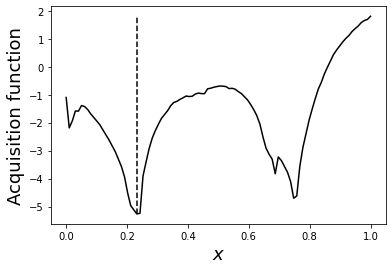

7/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2884.55it/s, 7 steps of size 1.91e-01. acc. prob=0.68] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.84      0.55      0.71      0.08      1.64   1875.60      1.00
         A2      0.57      0.34      0.49      0.09      1.05   3584.61      1.00
k_length[0]      1.44      1.95      0.83      0.03      3.21   5430.81      1.00
    k_scale      1.91      2.47      1.14      0.06      4.31   4435.89      1.00
      noise      2.79      1.99      2.33      0.39      5.35   2374.28      1.00
         w1      0.14      0.06      0.13      0.04      0.23   3223.97      1.00
         w2      0.09      0.05      0.08      0.00      0.16   2639.89      1.00
        x01      0.17      0.10      0.15      0.00      0.31   3455.41      1.00
        x02      0.72      0.06      0.73      0.62      0.80   2708.25      1.00
         y0      5.15      2.50      5.10      1.79      9.85   1745.59      1.00

Number of divergences: 148


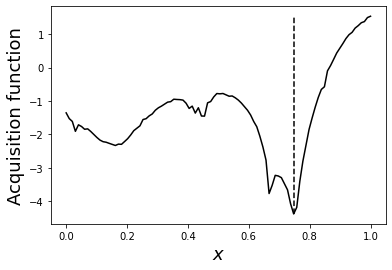

8/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2219.91it/s, 15 steps of size 1.18e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.85      0.53      0.74      0.09      1.61   2957.37      1.00
         A2      0.62      0.35      0.55      0.12      1.11   4136.33      1.00
k_length[0]      1.43      1.95      0.84      0.03      3.13   5544.53      1.00
    k_scale      1.99      2.70      1.19      0.03      4.43   4442.83      1.00
      noise      2.50      1.72      2.05      0.43      4.73   2747.31      1.00
         w1      0.14      0.06      0.13      0.05      0.23   4796.03      1.00
         w2      0.09      0.04      0.08      0.03      0.16   3437.58      1.00
        x01      0.16      0.10      0.15      0.00      0.31   2663.05      1.00
        x02      0.72      0.05      0.73      0.65      0.79   2322.13      1.00
         y0      5.35      2.50      5.39      1.99      9.87   2320.76      1.00

Number of divergences: 16


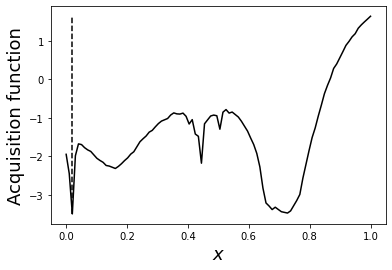

9/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2002.50it/s, 15 steps of size 1.20e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.83      0.50      0.74      0.12      1.56   2907.04      1.00
         A2      0.65      0.35      0.60      0.13      1.14   3585.60      1.00
k_length[0]      1.44      1.79      0.86      0.03      3.26   6389.13      1.00
    k_scale      1.82      2.41      1.09      0.04      4.08   5687.78      1.00
      noise      2.29      1.52      1.91      0.38      4.27   2608.56      1.00
         w1      0.13      0.06      0.13      0.04      0.21   5657.06      1.00
         w2      0.09      0.04      0.08      0.03      0.15   4053.84      1.00
        x01      0.19      0.08      0.17      0.05      0.32   2405.67      1.00
        x02      0.72      0.04      0.73      0.66      0.79   3492.82      1.00
         y0      5.78      2.44      5.89      2.42      9.99   2095.17      1.00

Number of divergences: 4


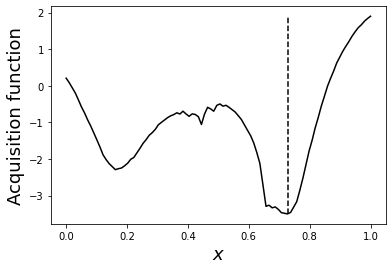

10/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:01<00:00, 1959.52it/s, 31 steps of size 1.64e-01. acc. prob=0.82]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.88      0.51      0.80      0.12      1.60   2722.66      1.00
         A2      0.67      0.34      0.62      0.16      1.17   3118.44      1.00
k_length[0]      1.39      1.91      0.78      0.03      3.21   5576.29      1.00
    k_scale      1.98      2.57      1.20      0.05      4.49   4615.18      1.00
      noise      1.89      1.28      1.56      0.26      3.55   2807.59      1.00
         w1      0.13      0.05      0.13      0.05      0.22   4592.39      1.00
         w2      0.09      0.04      0.08      0.03      0.14   3556.73      1.00
        x01      0.19      0.08      0.17      0.04      0.31   1752.63      1.00
        x02      0.73      0.04      0.73      0.67      0.78   2522.96      1.00
         y0      6.06      2.38      6.22      2.80     10.00   1884.84      1.01

Number of divergences: 29


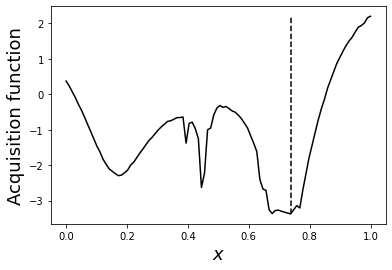

11/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2018.25it/s, 31 steps of size 1.58e-01. acc. prob=0.83]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.88      0.51      0.79      0.13      1.60   3163.76      1.00
         A2      0.67      0.34      0.62      0.18      1.18   4246.78      1.00
k_length[0]      1.40      1.90      0.78      0.03      3.30   3987.84      1.00
    k_scale      1.91      2.42      1.14      0.05      4.31   4423.64      1.00
      noise      1.76      1.10      1.49      0.38      3.29   2954.34      1.00
         w1      0.13      0.05      0.13      0.04      0.22   5174.73      1.00
         w2      0.09      0.04      0.08      0.03      0.14   4519.84      1.00
        x01      0.19      0.08      0.17      0.06      0.31   1934.87      1.01
        x02      0.73      0.04      0.73      0.67      0.78   2518.83      1.00
         y0      6.06      2.33      6.19      2.83     10.00   2439.91      1.01

Number of divergences: 9


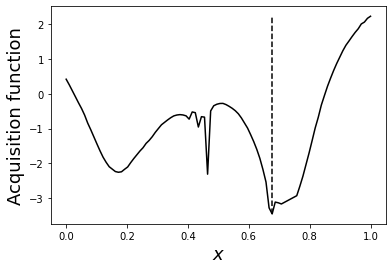

12/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:01<00:00, 1654.00it/s, 15 steps of size 1.40e-01. acc. prob=0.91]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         A1      0.90      0.52      0.81      0.11      1.65   3164.77      1.00
         A2      0.60      0.30      0.55      0.16      1.04   3767.85      1.00
k_length[0]      1.36      1.93      0.74      0.03      3.12   6293.71      1.00
    k_scale      2.04      2.58      1.20      0.05      4.58   4156.26      1.00
      noise      1.69      1.05      1.42      0.34      3.08   2571.89      1.00
         w1      0.14      0.05      0.13      0.05      0.22   4800.65      1.00
         w2      0.08      0.04      0.08      0.03      0.14   2955.91      1.00
        x01      0.19      0.08      0.17      0.08      0.32   2072.83      1.00
        x02      0.74      0.04      0.75      0.70      0.79   1680.54      1.00
         y0      6.04      2.31      6.19      2.89      9.94   2482.78      1.01

Number of divergences: 1


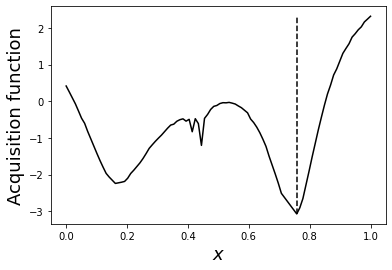

In [18]:
exploration_steps = 12
acq_fn = UCB  #EI

rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # Initiate GP model
    gp_model = GP1(1, RBFKernel)
    # Get/update GP posterior
    gp_model.fit(rng_key, X_train, y_train, num_warmup=1000, num_samples=1000, num_chains=10)
    # Compute acquisition 
    obj = acq_fn(rng_key_predict, gp_model, X_test, n=1)
    # Find maximum/minimum of acquisiton function to select the next "measurement" point
    next_point_idx = obj.argmax() if acq_fn in (EI, UE) else obj.argmin()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_acq(X_test, obj, next_point_idx)
    # Append to the arrays of measured points
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, measured_point)
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point)
    indices_test = jnp.delete(indices_test, next_point_idx)

Plot results together with GP prediction on the final set of discovered points:

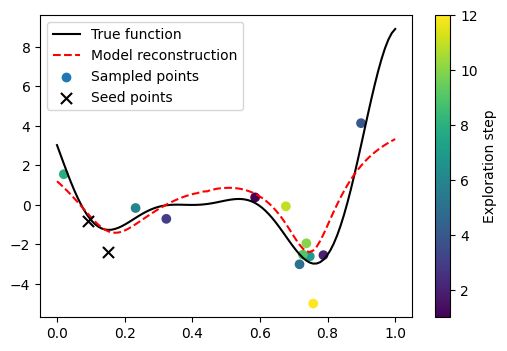

In [19]:
y_pred, _ = gp_model.predict(rng_key_predict, X)
plot_final_result(X_train, y_train, y_pred, num_seed_points=seed_points)

### Probabilistic model 2

Here we will use a 'wrong' function that still partially captures some trends in data.

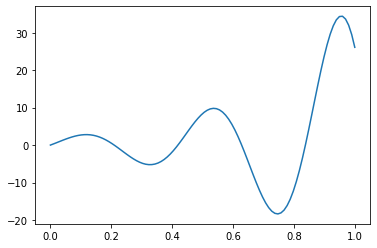

In [20]:
def oscfunc(x, params):
    return params["A"] * jnp.exp(params["a"] * x) * jnp.sin(params["b"] * x)

x = jnp.linspace(0, 1, 100)
y = oscfunc(x, {"a": 3, "b": 15, "A": 2})
plt.plot(x, y)

In [21]:
class GP2(ExactGP):

    def __init__(self, input_dim, kernel):
        super(GP2, self).__init__(input_dim, kernel)
        self.mean_fn = oscfunc

    def model(self, X, y):

        # Mean function prameters
        a = numpyro.sample("a", dist.Normal(3, 2))
        b = numpyro.sample("b", dist.Normal(10, 5))
        A = numpyro.sample("A", dist.LogNormal(0, 1))
        # kernel parameters
        with numpyro.plate('k_param', self.input_dim):
            length = numpyro.sample("k_length", dist.Uniform(0.0, 0.5))
        scale = numpyro.sample("k_scale", dist.LogNormal(0.0, 1))
        noise = numpyro.sample("noise", dist.LogNormal(0.0, 1))
        # compute mean function
        mean_fn_params = {"a": a, "b": b, "A": A}
        
        f_loc = self.mean_fn(X, mean_fn_params).squeeze()

        # compute kernel
        k = self.kernel(
            X, X,
            {"k_length": length, "k_scale": scale},
            noise
        )
        # sample y according to the standard gaussian process formula
        numpyro.sample(
            "y",
            dist.MultivariateNormal(loc=f_loc, covariance_matrix=k),
            obs=y,
        )

Initialize "train/test" data:

In [22]:
seed_points = 2

X, Y, truefunc, _ = get_data(noise_level=1)

(X_train, y_train, X_test, y_test,
 indices_train, indices_test) = get_training_data(X, Y, seed_points, 10)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(2,) (98,) (2,) (98,)


Run Bayesian optimization:

1/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 5994.21it/s, 7 steps of size 5.49e-01. acc. prob=0.85]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.83      0.99      0.55      0.04      1.67    665.74      1.01
          a      2.65      1.97      2.66     -0.60      5.77   8682.18      1.00
          b      9.22      6.84      9.26     -2.54     19.78   4569.95      1.00
k_length[0]      0.25      0.14      0.25      0.06      0.50  11767.35      1.00
    k_scale      2.09      2.26      1.42      0.09      4.51   8484.47      1.00
      noise      1.92      2.03      1.31      0.05      4.04   7862.90      1.00

Number of divergences: 29


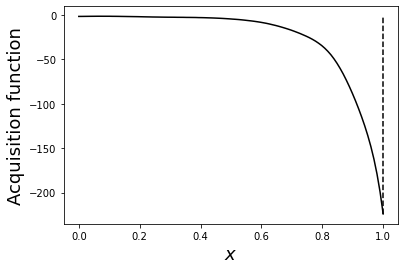

2/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 3818.88it/s, 63 steps of size 4.75e-02. acc. prob=0.67]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.75      0.66      0.57      0.05      1.52     51.90      1.08
          a      3.24      0.97      3.20      1.65      4.85     93.83      1.07
          b      8.27      5.10      8.26      0.95     15.42      5.40      5.52
k_length[0]      0.25      0.14      0.24      0.06      0.50    783.29      1.01
    k_scale      2.23      2.56      1.48      0.05      4.73   3012.42      1.01
      noise      2.46      3.09      1.51      0.08      5.12     68.69      1.12

Number of divergences: 429


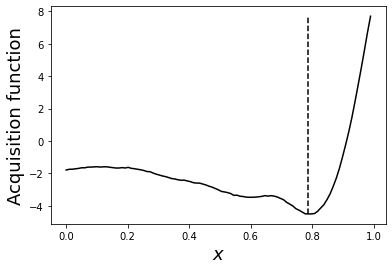

3/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 3467.65it/s, 31 steps of size 5.74e-02. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.60      0.47      0.48      0.05      1.21    415.86      1.02
          a      3.08      0.87      3.05      1.75      4.54   1288.60      1.02
          b     12.61      5.01     13.64      6.96     20.63      5.30      5.08
k_length[0]      0.25      0.14      0.24      0.05      0.48   5741.69      1.00
    k_scale      2.22      2.43      1.51      0.08      4.81   4887.75      1.00
      noise      2.12      2.47      1.41      0.07      4.41   1440.25      1.01

Number of divergences: 33


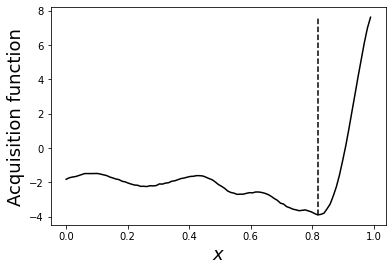

4/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 3704.71it/s, 31 steps of size 1.32e-01. acc. prob=0.89]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.53      0.42      0.42      0.06      1.06   3549.81      1.01
          a      3.18      0.85      3.18      1.79      4.51   2005.69      1.01
          b     10.96      4.50      7.74      6.68     19.67      5.34      5.27
k_length[0]      0.24      0.14      0.24      0.04      0.48   5776.72      1.00
    k_scale      2.27      2.59      1.57      0.09      4.72   4734.57      1.00
      noise      1.79      1.84      1.26      0.11      3.71   2308.29      1.01

Number of divergences: 18


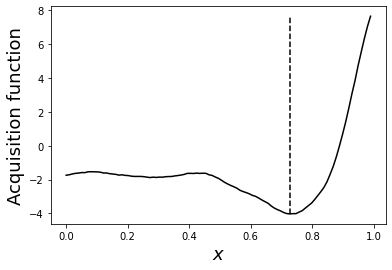

5/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 3191.77it/s, 31 steps of size 1.14e-01. acc. prob=0.88]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.45      0.35      0.35      0.04      0.87   3854.19      1.01
          a      3.34      0.84      3.34      2.02      4.76   1825.11      1.02
          b     10.16      3.47      7.63      6.95     14.80      5.05     10.48
k_length[0]      0.24      0.14      0.22      0.03      0.46   5593.07      1.00
    k_scale      2.11      2.38      1.45      0.07      4.53   4617.72      1.01
      noise      1.51      1.40      1.09      0.09      3.11   4806.81      1.00

Number of divergences: 11


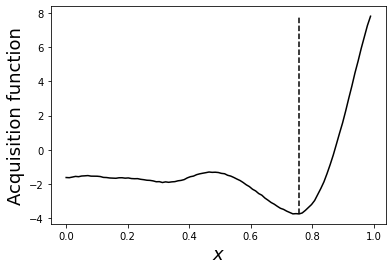

6/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2873.42it/s, 31 steps of size 1.06e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.51      0.39      0.41      0.06      0.99   4596.98      1.00
          a      3.25      0.79      3.25      2.01      4.55   4250.28      1.00
          b      8.77      2.89      7.40      6.85     14.67      5.06      9.63
k_length[0]      0.25      0.14      0.24      0.04      0.48   7210.05      1.00
    k_scale      1.83      2.00      1.26      0.07      3.97   5956.76      1.00
      noise      1.97      1.46      1.58      0.36      3.69   5278.08      1.00

Number of divergences: 0


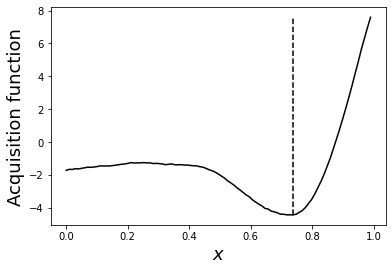

7/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 3128.06it/s, 31 steps of size 1.34e-01. acc. prob=0.93]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.47      0.36      0.38      0.05      0.91   3993.58      1.00
          a      3.31      0.83      3.31      1.96      4.63   2907.38      1.01
          b      8.74      2.85      7.40      6.81     14.53      5.06      9.11
k_length[0]      0.24      0.14      0.24      0.00      0.44   6446.06      1.00
    k_scale      1.83      2.06      1.24      0.03      3.88   3722.30      1.00
      noise      2.03      1.39      1.67      0.43      3.81   4554.22      1.00

Number of divergences: 2


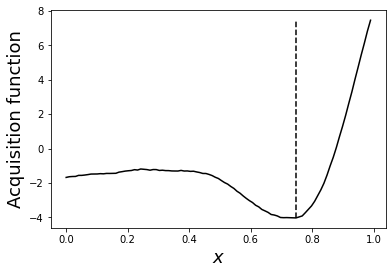

8/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2248.81it/s, 31 steps of size 8.99e-02. acc. prob=0.96]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.45      0.34      0.36      0.05      0.87   4161.26      1.00
          a      3.34      0.81      3.34      2.04      4.65   1853.23      1.01
          b      9.44      3.24      7.47      6.88     14.64      5.05     10.65
k_length[0]      0.24      0.14      0.23      0.04      0.48   7038.43      1.00
    k_scale      1.88      2.16      1.27      0.07      3.96   4529.92      1.00
      noise      1.75      1.13      1.45      0.35      3.18   4740.56      1.00

Number of divergences: 1


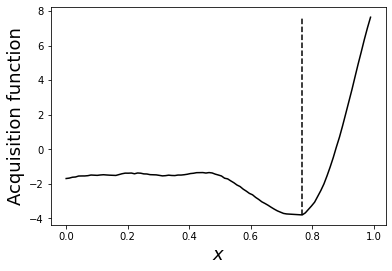

9/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2161.68it/s, 31 steps of size 1.10e-01. acc. prob=0.92]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.44      0.34      0.35      0.05      0.84   3837.54      1.00
          a      3.39      0.81      3.37      2.02      4.66   3156.54      1.01
          b      9.43      3.26      7.44      6.89     14.67      5.04     11.03
k_length[0]      0.24      0.14      0.23      0.05      0.48   6028.17      1.00
    k_scale      1.91      2.09      1.31      0.07      4.03   4800.37      1.00
      noise      1.52      0.96      1.28      0.37      2.74   3714.35      1.01

Number of divergences: 0


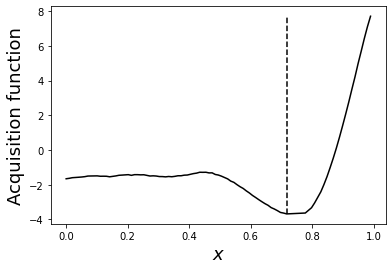

10/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:01<00:00, 1901.15it/s, 23 steps of size 9.42e-02. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.41      0.31      0.33      0.06      0.78   4262.43      1.01
          a      3.46      0.79      3.45      2.29      4.86   2487.15      1.01
          b      9.43      3.30      7.42      6.86     14.69      5.04     11.78
k_length[0]      0.24      0.14      0.23      0.04      0.47   5635.93      1.00
    k_scale      1.90      2.03      1.31      0.06      3.99   5102.33      1.00
      noise      1.34      0.81      1.15      0.38      2.35   4896.73      1.00

Number of divergences: 0


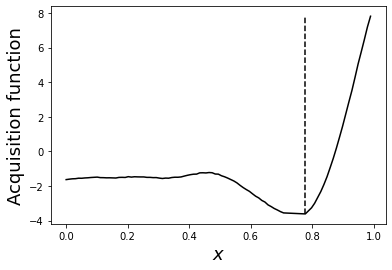

11/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:00<00:00, 2093.99it/s, 31 steps of size 1.11e-01. acc. prob=0.94]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.41      0.31      0.32      0.04      0.78   3971.88      1.00
          a      3.46      0.79      3.46      2.18      4.74   3495.89      1.01
          b      8.74      2.88      7.38      6.82     14.58      5.05     10.35
k_length[0]      0.24      0.14      0.23      0.04      0.47   5978.39      1.00
    k_scale      1.91      2.10      1.30      0.07      4.07   4382.42      1.00
      noise      1.31      0.74      1.13      0.41      2.26   5993.26      1.00

Number of divergences: 0


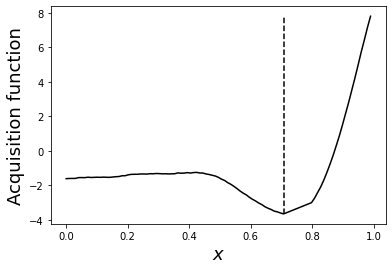

12/12


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: There are not enough devices to run parallel chains: expected 10 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(10)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
sample: 100%|██████████| 2000/2000 [00:01<00:00, 1726.80it/s, 31 steps of size 1.15e-01. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          A      0.41      0.31      0.33      0.04      0.78   3954.04      1.00
          a      3.46      0.77      3.46      2.22      4.72   3823.59      1.01
          b      8.76      2.92      7.38      6.84     14.69      5.04     11.20
k_length[0]      0.25      0.14      0.24      0.04      0.47   6493.03      1.00
    k_scale      1.85      1.93      1.28      0.08      3.86   5572.53      1.00
      noise      1.25      0.67      1.10      0.40      2.12   5336.66      1.00

Number of divergences: 0


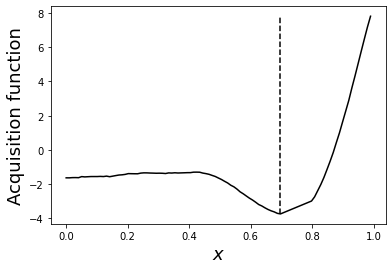

In [23]:
exploration_steps = 12
acq_fn = UCB  #EI

rng_key, rng_key_predict = jra.split(jra.PRNGKey(0))

for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))
    # Initiate GP model
    gp_model = GP2(1, RBFKernel)
    # Get/update GP posterior
    gp_model.fit(rng_key, X_train, y_train, num_warmup=1000, num_samples=1000, num_chains=10)
    # Compute acquisition 
    obj = acq_fn(rng_key_predict, gp_model, X_test, n=1)
    # Find maximum/minimum of acquisiton function to select the next "measurement" point
    next_point_idx = obj.argmax() if acq_fn in (EI, UE) else obj.argmin()
    next_point = indices_test[next_point_idx]
    # Do "measurement"
    measured_point = y_test[next_point_idx]
    # Plot current result
    plot_acq(X_test, obj, next_point_idx)
    # Append to the arrays of measured points
    X_train = jnp.append(X_train, X_test[next_point_idx][None], 0)
    X_test = jnp.delete(X_test, next_point_idx, 0)
    y_train = jnp.append(y_train, measured_point)
    y_test = jnp.delete(y_test, next_point_idx)
    indices_train = jnp.append(indices_train, next_point)
    indices_test = jnp.delete(indices_test, next_point_idx)

Plot results together with GP prediction on the final set of discovered points:

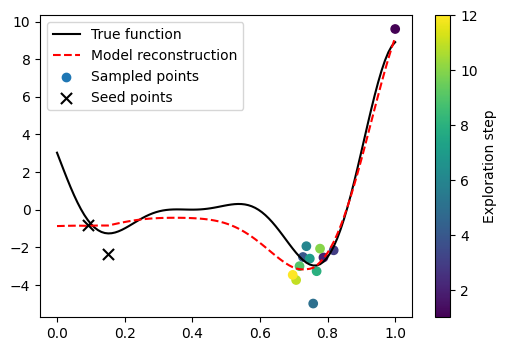

In [24]:
y_pred, _ = gp_model.predict(rng_key_predict, X)
plot_final_result(X_train, y_train, y_pred, num_seed_points=seed_points)